# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
# os.chdir("/content/drive/MyDrive/BT4221 Project/Processing   Model /Data")

In [ ]:
os.chdir("/content/drive/MyDrive/AY21_22/2021/BT4221/BT4221 Project/Processing   Model /Data")
# os.chdir('/content/drive/MyDrive/BT4221 Project/Processing   Model /Data')

# Import Packages Required

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow
import pandas as pd

%matplotlib inline
from glob import glob

In [ ]:
# Set seed
seed(1)
tensorflow.random.set_seed(2)

# Get File Directory & Function

In [ ]:
train_data_dir = '/content/drive/MyDrive/AY21_22/2021/BT4221/BT4221 Project/Processing   Model /Data/train'
test_data_dir = '/content/drive/MyDrive/AY21_22/2021/BT4221/BT4221 Project/Processing   Model /Data/test'
# train_data_dir = '/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/train'
# test_data_dir = '/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/test'

Pneumona_img = os.listdir(train_data_dir + "/PNEUMONIA")
Normal_img = os.listdir(train_data_dir + "/NORMAL")
COVID19_img = os.listdir(train_data_dir + "/COVID19")

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

# Preprocessing

In [ ]:
# To Tackle Issue of Imbalanced Dataset during Model Fitting
pneumonia_cases = len(Pneumona_img)
normal_cases = len(Normal_img)
covid_cases = len(COVID19_img)

pneumonia_weight = pneumonia_cases / (pneumonia_cases + normal_cases + covid_cases)
normal_weight = normal_cases / (pneumonia_cases + normal_cases + covid_cases)
covid_weight = covid_cases / (pneumonia_cases + normal_cases + covid_cases)

class_weight = {0: covid_weight, 1: normal_weight,
                2: pneumonia_weight}

print(f"Weight for class 0: {covid_weight:.2f}")
print(f"Weight for class 1: {normal_weight:.2f}")
print(f"Weight for class 2: {pneumonia_weight:.2f}")

Weight for class 0: 0.22
Weight for class 1: 0.21
Weight for class 2: 0.57


In [ ]:
img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224)

test_datagen = ImageDataGenerator(rescale = 1./224)

train_generator = train_datagen.flow_from_directory(directory = train_data_dir,
                                                        target_size = tuple(img_size),
                                                        batch_size = 8,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                        target_size = tuple(img_size),
                                                        batch_size = 1,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


# VGG Set Up

In [ ]:
baseModel = VGG16(input_shape = img_size + [3], weights='imagenet', include_top=False)
for layer in baseModel.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


# 0 Dropout Layer

## 0.1 Old

In [ ]:
model =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model = Flatten()(model)

model = Dense(units = 256, activation = 'relu')(model)
model = Dense(units = 128, activation = 'relu')(model)
model = Dense(units = 64, activation = 'relu')(model)


# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model)
model = Model(inputs = baseModel.input, outputs = predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
CheckPointCallback = ModelCheckpoint("base_model.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

In [ ]:
seed(1)
tensorflow.random.set_seed(2)

history = model.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback],
                    verbose = 1)

Epoch 1/25
755/755 [==============================] - 1558s 2s/step - loss: 0.0799 - accuracy: 0.9027 - val_loss: 0.1716 - val_accuracy: 0.9363

Epoch 00001: val_accuracy improved from inf to 0.93634, saving model to base_model.h5
Epoch 2/25
755/755 [==============================] - 245s 324ms/step - loss: 0.0410 - accuracy: 0.9501 - val_loss: 0.1677 - val_accuracy: 0.9449

Epoch 00002: val_accuracy did not improve from 0.93634
Epoch 3/25
755/755 [==============================] - 242s 320ms/step - loss: 0.0395 - accuracy: 0.9504 - val_loss: 0.1441 - val_accuracy: 0.9519

Epoch 00003: val_accuracy did not improve from 0.93634
Epoch 4/25
755/755 [==============================] - 243s 321ms/step - loss: 0.0304 - accuracy: 0.9610 - val_loss: 0.0904 - val_accuracy: 0.9635

Epoch 00004: val_accuracy did not improve from 0.93634
Epoch 5/25
755/755 [==============================] - 240s 318ms/step - loss: 0.0268 - accuracy: 0.9659 - val_loss: 0.0977 - val_accuracy: 0.9666

Epoch 00005: val

In [ ]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 58s 45ms/step - loss: 0.2244 - accuracy: 0.9728
Test Accuracy: 97.28%
755/755 [==============================] - 185s 246ms/step - loss: 0.0011 - accuracy: 0.9997
Train Accuracy: 99.97%


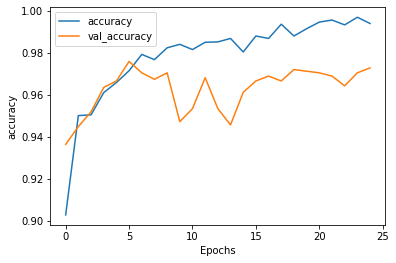

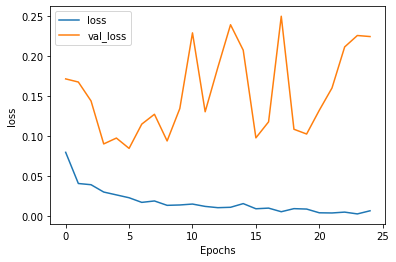

In [ ]:
plotting(history, "accuracy")
plotting(history, "loss")

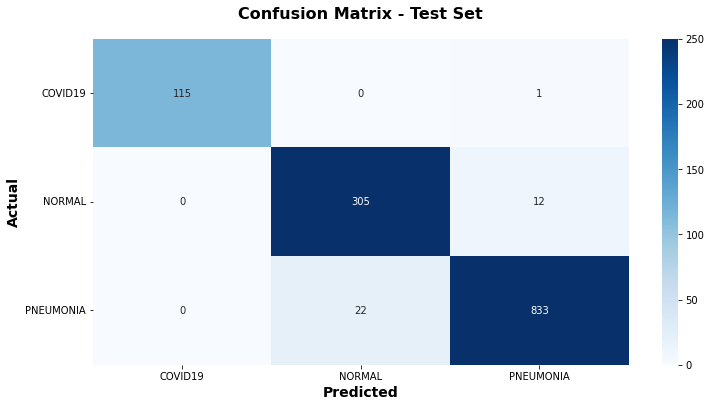

In [ ]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 0.2 New (After consult with prof)

In [ ]:
model_1 =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model_1 = Flatten()(model_1)

model_1 = Dense(units = 256, activation = 'relu')(model_1)
model_1 = Dense(units = 256, activation = 'relu')(model_1)
model_1 = Dense(units = 256, activation = 'relu')(model_1)

# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model_1)
model_1 = Model(inputs = baseModel.input, outputs = predictions)
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model_1.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
CheckPointCallback = ModelCheckpoint("vgg_baseline.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

In [ ]:
seed(1)
tensorflow.random.set_seed(2)

history_1 = model_1.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback],
                    verbose = 1)

Epoch 1/25
755/755 [==============================] - 1734s 2s/step - loss: 0.0873 - accuracy: 0.8977 - val_loss: 0.3464 - val_accuracy: 0.8991

Epoch 00001: val_accuracy improved from -inf to 0.89907, saving model to vgg_baseline.h5
Epoch 2/25
755/755 [==============================] - 238s 315ms/step - loss: 0.0429 - accuracy: 0.9494 - val_loss: 0.0957 - val_accuracy: 0.9596

Epoch 00002: val_accuracy improved from 0.89907 to 0.95963, saving model to vgg_baseline.h5
Epoch 3/25
755/755 [==============================] - 235s 312ms/step - loss: 0.0334 - accuracy: 0.9579 - val_loss: 0.0926 - val_accuracy: 0.9682

Epoch 00003: val_accuracy improved from 0.95963 to 0.96817, saving model to vgg_baseline.h5
Epoch 4/25
755/755 [==============================] - 234s 309ms/step - loss: 0.0282 - accuracy: 0.9649 - val_loss: 0.1557 - val_accuracy: 0.9371

Epoch 00004: val_accuracy did not improve from 0.96817
Epoch 5/25
755/755 [==============================] - 233s 308ms/step - loss: 0.0244 -

In [ ]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model_1.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model_1.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 59s 45ms/step - loss: 0.1816 - accuracy: 0.9651
Test Accuracy: 96.51%
755/755 [==============================] - 193s 255ms/step - loss: 0.0072 - accuracy: 0.9983
Train Accuracy: 99.83%


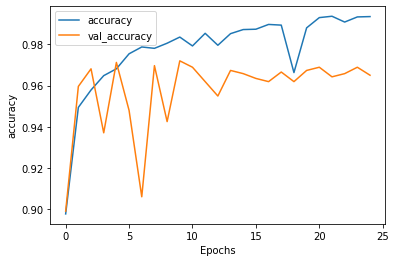

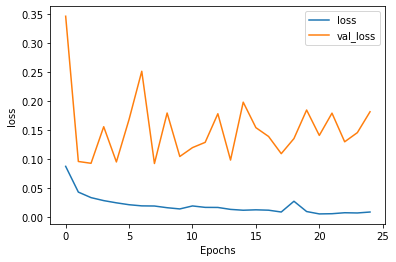

In [ ]:
plotting(history_1, "accuracy")
plotting(history_1, "loss")

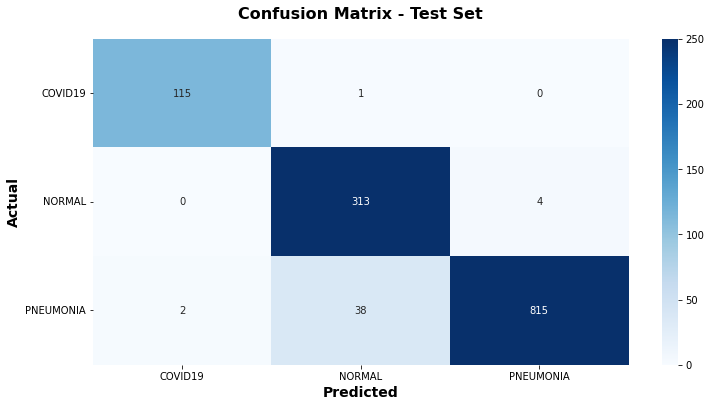

In [ ]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model_1.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

# 1 Dropout Layer

## 1.1 Old

In [ ]:
model_1 =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model_1 = Flatten()(model_1)

model_1 = Dense(units = 256, activation = 'relu')(model_1)
model_1 = Dropout(0.2)(model_1)
model_1 = Dense(units = 128, activation = 'relu')(model_1)
model_1 = Dense(units = 64, activation = 'relu')(model_1)

# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model_1)
model_1 = Model(inputs = baseModel.input, outputs = predictions)
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model_1.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
CheckPointCallback = ModelCheckpoint("model_1.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

In [ ]:
seed(1)
tensorflow.random.set_seed(2)

history_1 = model_1.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback],
                    verbose = 1)

Epoch 1/25
755/755 [==============================] - 1503s 2s/step - loss: 0.1152 - accuracy: 0.8744 - val_loss: 0.1582 - val_accuracy: 0.9418

Epoch 00001: val_accuracy improved from -inf to 0.94177, saving model to model_1.h5
Epoch 2/25
755/755 [==============================] - 236s 312ms/step - loss: 0.0571 - accuracy: 0.9340 - val_loss: 0.1278 - val_accuracy: 0.9542

Epoch 00002: val_accuracy improved from 0.94177 to 0.95419, saving model to model_1.h5
Epoch 3/25
755/755 [==============================] - 230s 305ms/step - loss: 0.0520 - accuracy: 0.9387 - val_loss: 0.0967 - val_accuracy: 0.9620

Epoch 00003: val_accuracy improved from 0.95419 to 0.96196, saving model to model_1.h5
Epoch 4/25
755/755 [==============================] - 227s 300ms/step - loss: 0.0401 - accuracy: 0.9511 - val_loss: 0.1329 - val_accuracy: 0.9589

Epoch 00004: val_accuracy did not improve from 0.96196
Epoch 5/25
755/755 [==============================] - 226s 299ms/step - loss: 0.0400 - accuracy: 0.94

In [ ]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model_1.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model_1.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 56s 43ms/step - loss: 0.0885 - accuracy: 0.9728
Test Accuracy: 97.28%
755/755 [==============================] - 184s 244ms/step - loss: 0.0437 - accuracy: 0.9945
Train Accuracy: 99.45%


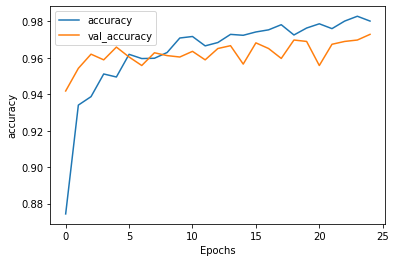

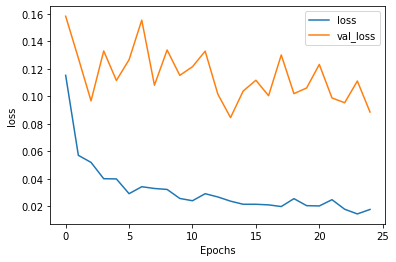

In [ ]:
plotting(history_1, "accuracy")
plotting(history_1, "loss")

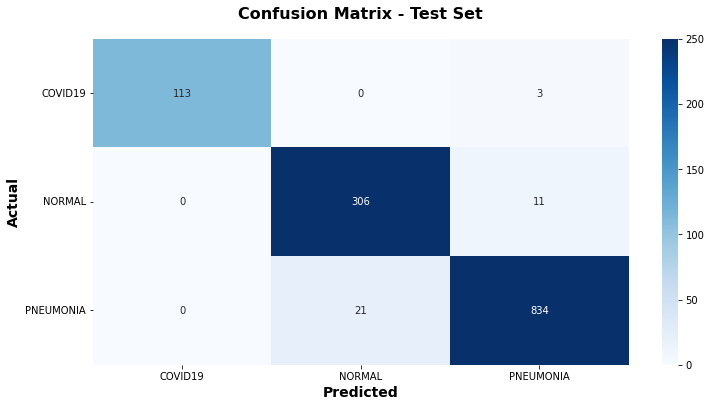

In [ ]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model_1.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 1.2 New (After consult with Prof)

In [ ]:
model_1 =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model_1 = Flatten()(model_1)

model_1 = Dense(units = 256, activation = 'relu')(model_1)
model_1 = Dropout(0.5)(model_1)
model_1 = Dense(units = 256, activation = 'relu')(model_1)
model_1 = Dense(units = 256, activation = 'relu')(model_1)

# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model_1)
model_1 = Model(inputs = baseModel.input, outputs = predictions)
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model_1.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
CheckPointCallback = ModelCheckpoint("vgg_1dropout_new.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

In [ ]:
seed(1)
tensorflow.random.set_seed(2)

history_1 = model_1.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback],
                    verbose = 1)

Epoch 1/25
755/755 [==============================] - 1563s 2s/step - loss: 0.1610 - accuracy: 0.8051 - val_loss: 0.2207 - val_accuracy: 0.9262

Epoch 00001: val_accuracy improved from -inf to 0.92624, saving model to vgg_1dropout_new.h5
Epoch 2/25
755/755 [==============================] - 240s 318ms/step - loss: 0.1219 - accuracy: 0.8018 - val_loss: 0.3045 - val_accuracy: 0.9526

Epoch 00002: val_accuracy improved from 0.92624 to 0.95264, saving model to vgg_1dropout_new.h5
Epoch 3/25
755/755 [==============================] - 238s 315ms/step - loss: 0.1350 - accuracy: 0.7553 - val_loss: 0.2923 - val_accuracy: 0.9425

Epoch 00003: val_accuracy did not improve from 0.95264
Epoch 4/25
755/755 [==============================] - 237s 315ms/step - loss: 0.1298 - accuracy: 0.8059 - val_loss: 0.2976 - val_accuracy: 0.9387

Epoch 00004: val_accuracy did not improve from 0.95264
Epoch 5/25
755/755 [==============================] - 250s 330ms/step - loss: 0.1232 - accuracy: 0.8081 - val_loss:

In [ ]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model_1.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model_1.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 59s 46ms/step - loss: 0.2344 - accuracy: 0.9573
Test Accuracy: 95.73%
755/755 [==============================] - 191s 253ms/step - loss: 0.1845 - accuracy: 0.9730
Train Accuracy: 97.30%


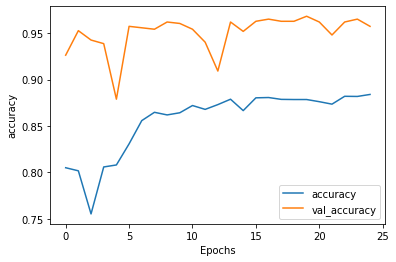

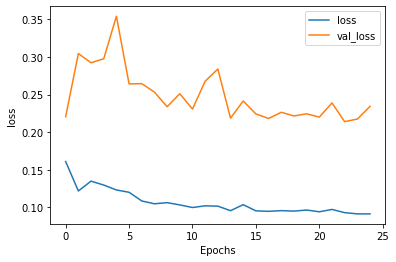

In [ ]:
plotting(history_1, "accuracy")
plotting(history_1, "loss")

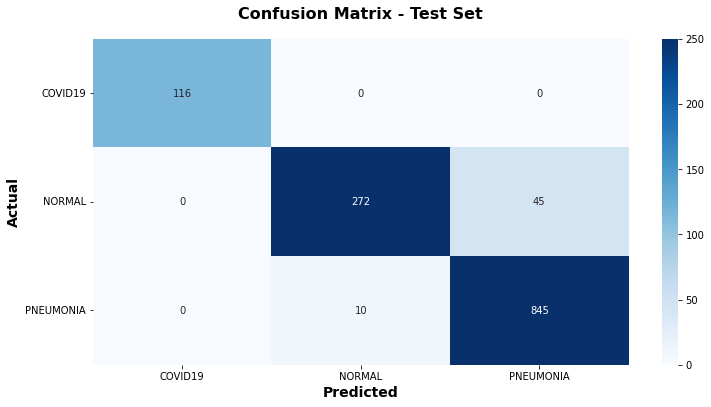

In [ ]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model_1.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 1.3 (Old Version) 0.5 Dropout

In [ ]:
model_1 =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model_1 = Flatten()(model_1)

model_1 = Dense(units = 256, activation = 'relu')(model_1)
model_1 = Dropout(0.5)(model_1)
model_1 = Dense(units = 128, activation = 'relu')(model_1)
model_1 = Dense(units = 64, activation = 'relu')(model_1)

# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model_1)
model_1 = Model(inputs = baseModel.input, outputs = predictions)
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model_1.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
CheckPointCallback = ModelCheckpoint("model_5_1.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

In [ ]:
seed(1)
tensorflow.random.set_seed(2)

history_1 = model_1.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback],
                    verbose = 1)

Epoch 1/25
755/755 [==============================] - 4088s 5s/step - loss: 0.1638 - accuracy: 0.7905 - val_loss: 0.1991 - val_accuracy: 0.9224

Epoch 00001: val_accuracy improved from -inf to 0.92236, saving model to model_5_1.h5
Epoch 2/25
755/755 [==============================] - 237s 314ms/step - loss: 0.0907 - accuracy: 0.8735 - val_loss: 0.1823 - val_accuracy: 0.9293

Epoch 00002: val_accuracy improved from 0.92236 to 0.92935, saving model to model_5_1.h5
Epoch 3/25
755/755 [==============================] - 236s 312ms/step - loss: 0.0808 - accuracy: 0.8730 - val_loss: 0.2953 - val_accuracy: 0.9519

Epoch 00003: val_accuracy improved from 0.92935 to 0.95186, saving model to model_5_1.h5
Epoch 4/25
755/755 [==============================] - 238s 315ms/step - loss: 0.0767 - accuracy: 0.9087 - val_loss: 0.1642 - val_accuracy: 0.9542

Epoch 00004: val_accuracy improved from 0.95186 to 0.95419, saving model to model_5_1.h5
Epoch 5/25
755/755 [==============================] - 235s 31

In [ ]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model_1.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model_1.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 57s 44ms/step - loss: 0.0904 - accuracy: 0.9736
Test Accuracy: 97.36%
755/755 [==============================] - 183s 242ms/step - loss: 0.0395 - accuracy: 0.9869
Train Accuracy: 98.69%


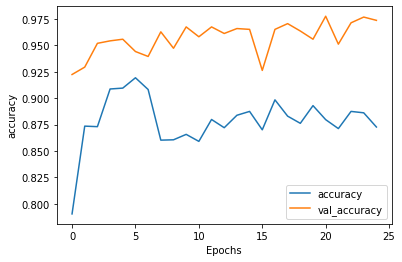

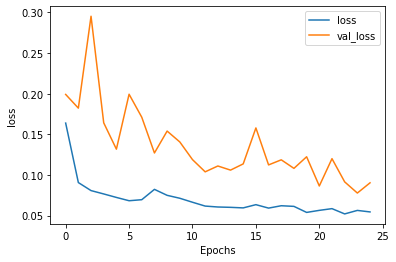

In [ ]:
plotting(history_1, "accuracy")
plotting(history_1, "loss")

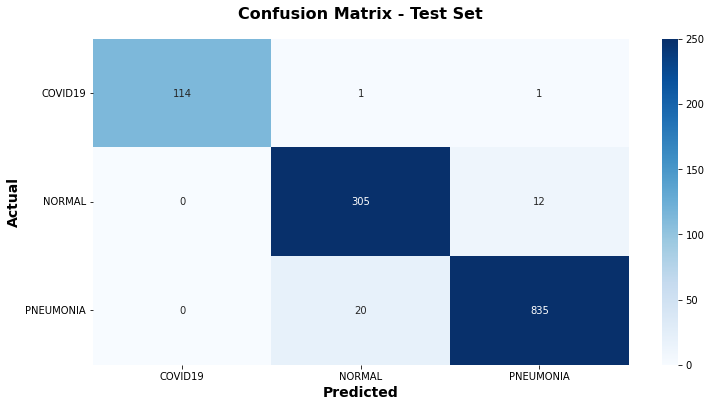

In [ ]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model_1.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## Test the Heatmap

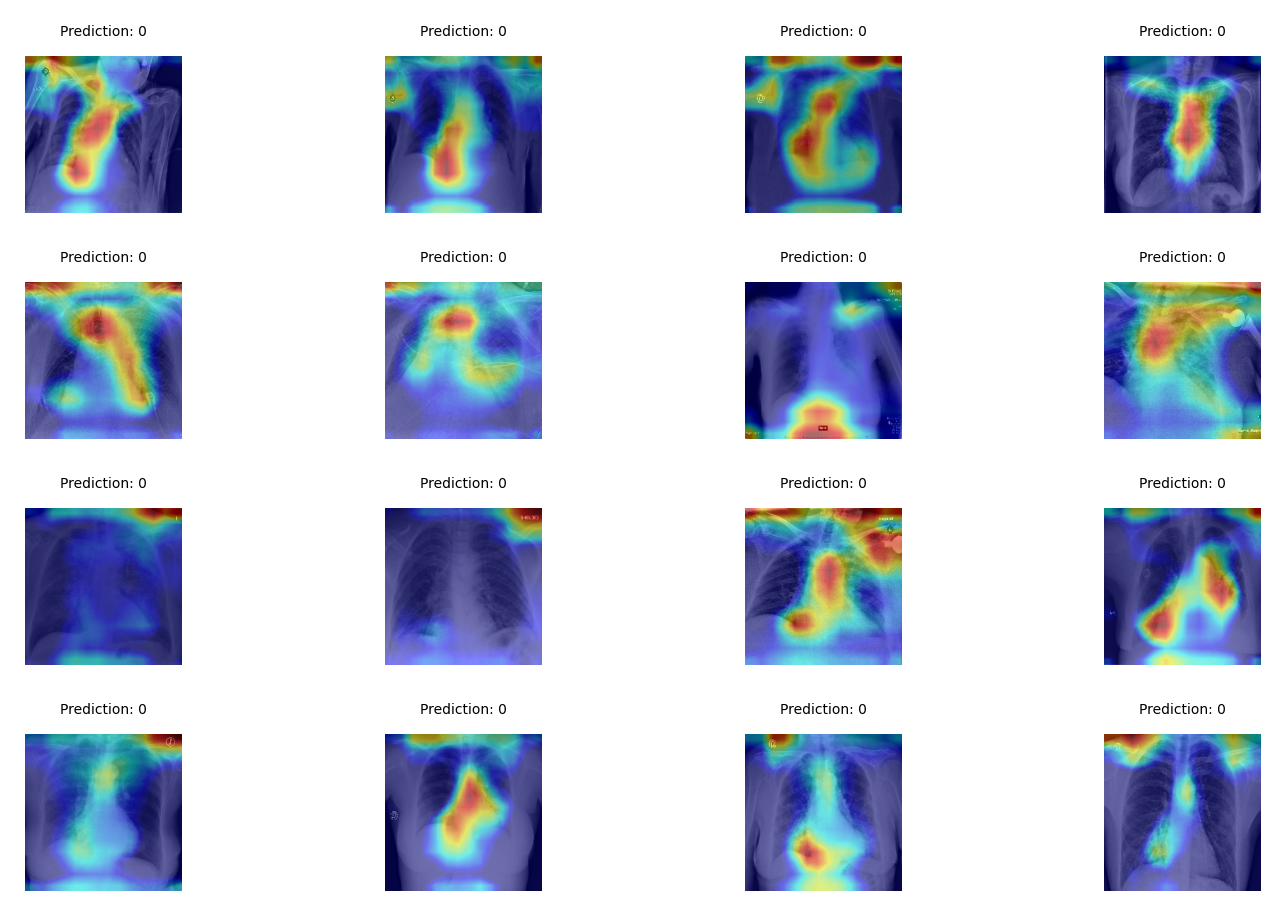

In [ ]:
os.chdir("/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/vizgradcam")


from gradcam import VizGradCAM
for i in range(16):
  # define subplot
  plt.rcParams["figure.dpi"] = 250
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  img = test_generator.__getitem__(i)
  preview_img, preview_labels = img
  pred = model_1.predict(preview_img[0].reshape(1, 224, 224, 3))
  plt.title("Prediction: " + str(pred.argmax()),fontsize = 4)
  plt.axis('off')
  VizGradCAM(model_1, preview_img[0])

# 2 Dropout Layers

In [ ]:
model_2 =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model_2 = Flatten()(model_2)

model_2 = Dense(units = 256, activation = 'relu')(model_2)
model_2 = Dropout(0.2)(model_2)
model_2 = Dense(units = 128, activation = 'relu')(model_2)
model_2 = Dropout(0.2)(model_2)
model_2 = Dense(units = 64, activation = 'relu')(model_2)

# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model_2)
model_2 = Model(inputs = baseModel.input, outputs = predictions)
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model_2.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
CheckPointCallback = ModelCheckpoint("model2.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

In [ ]:
seed(1)
tensorflow.random.set_seed(2)

history_2 = model_2.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback],
                    verbose = 1)

Epoch 1/25
755/755 [==============================] - 240s 316ms/step - loss: 0.1202 - accuracy: 0.8641 - val_loss: 0.1888 - val_accuracy: 0.9418

Epoch 00001: val_accuracy improved from -inf to 0.94177, saving model to model2.h5
Epoch 2/25
755/755 [==============================] - 235s 311ms/step - loss: 0.0630 - accuracy: 0.9251 - val_loss: 0.1629 - val_accuracy: 0.9565

Epoch 00002: val_accuracy improved from 0.94177 to 0.95652, saving model to model2.h5
Epoch 3/25
755/755 [==============================] - 238s 315ms/step - loss: 0.0474 - accuracy: 0.9420 - val_loss: 0.1420 - val_accuracy: 0.9472

Epoch 00003: val_accuracy did not improve from 0.95652
Epoch 4/25
755/755 [==============================] - 235s 311ms/step - loss: 0.0505 - accuracy: 0.9345 - val_loss: 0.1183 - val_accuracy: 0.9589

Epoch 00004: val_accuracy improved from 0.95652 to 0.95885, saving model to model2.h5
Epoch 5/25
755/755 [==============================] - 236s 313ms/step - loss: 0.0525 - accuracy: 0.938

In [ ]:
evaluation = model_2.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model_2.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 61s 48ms/step - loss: 0.1341 - accuracy: 0.9720
Test Accuracy: 97.20%
755/755 [==============================] - 197s 261ms/step - loss: 0.0199 - accuracy: 0.9930
Train Accuracy: 99.30%


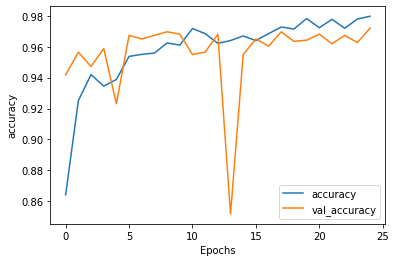

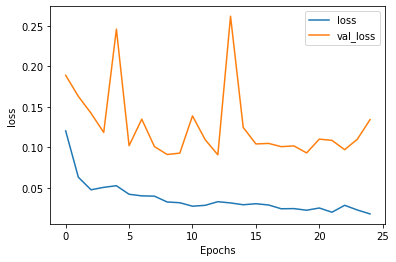

In [ ]:
plotting(history_2, "accuracy")
plotting(history_2, "loss")

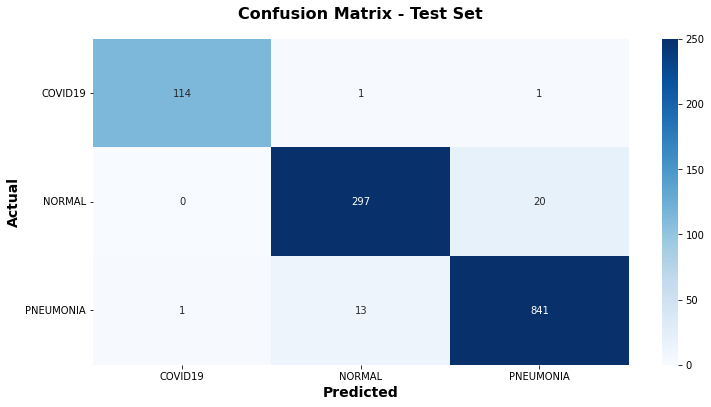

In [ ]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model_2.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

# 3 Dropout Layers

In [ ]:
model_3 =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model_3 = Flatten()(model_3)

model_3 = Dense(units = 256, activation = 'relu')(model_3)
model_3 = Dropout(0.2)(model_3)
model_3 = Dense(units = 128, activation = 'relu')(model_3)
model_3 = Dropout(0.2)(model_3)
model_3 = Dense(units = 64, activation = 'relu')(model_3)
model_3 = Dropout(0.2)(model_3)

# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model_3)
model_3 = Model(inputs = baseModel.input, outputs = predictions)
model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model_3.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
CheckPointCallback = ModelCheckpoint("model3.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

In [ ]:
seed(1)
tensorflow.random.set_seed(2)

history_3 = model_3.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback],
                    verbose = 1)

Epoch 1/25
755/755 [==============================] - 4371s 6s/step - loss: 0.1375 - accuracy: 0.8434 - val_loss: 0.1979 - val_accuracy: 0.9099

Epoch 00001: val_accuracy improved from -inf to 0.90994, saving model to model3.h5
Epoch 2/25
755/755 [==============================] - 243s 321ms/step - loss: 0.0627 - accuracy: 0.9266 - val_loss: 0.2116 - val_accuracy: 0.9169

Epoch 00002: val_accuracy improved from 0.90994 to 0.91693, saving model to model3.h5
Epoch 3/25
755/755 [==============================] - 235s 312ms/step - loss: 0.0490 - accuracy: 0.9378 - val_loss: 0.1306 - val_accuracy: 0.9519

Epoch 00003: val_accuracy improved from 0.91693 to 0.95186, saving model to model3.h5
Epoch 4/25
755/755 [==============================] - 235s 311ms/step - loss: 0.0490 - accuracy: 0.9378 - val_loss: 0.1117 - val_accuracy: 0.9604

Epoch 00004: val_accuracy improved from 0.95186 to 0.96040, saving model to model3.h5
Epoch 5/25
755/755 [==============================] - 234s 311ms/step - l

In [ ]:
evaluation = model_3.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model_3.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 60s 46ms/step - loss: 0.1097 - accuracy: 0.9658
Test Accuracy: 96.58%
755/755 [==============================] - 184s 244ms/step - loss: 0.0317 - accuracy: 0.9874
Train Accuracy: 98.74%


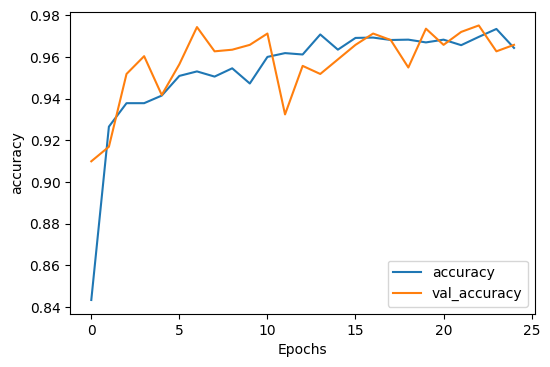

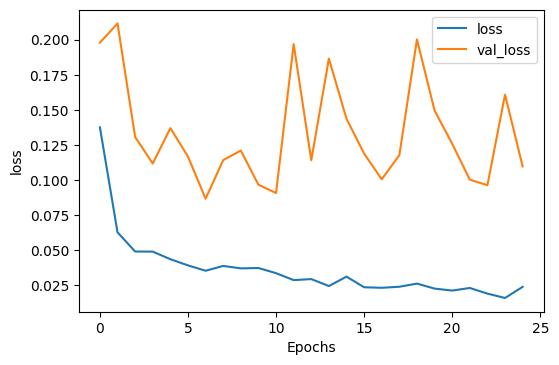

In [ ]:
plotting(history_3, "accuracy")
plotting(history_3, "loss")

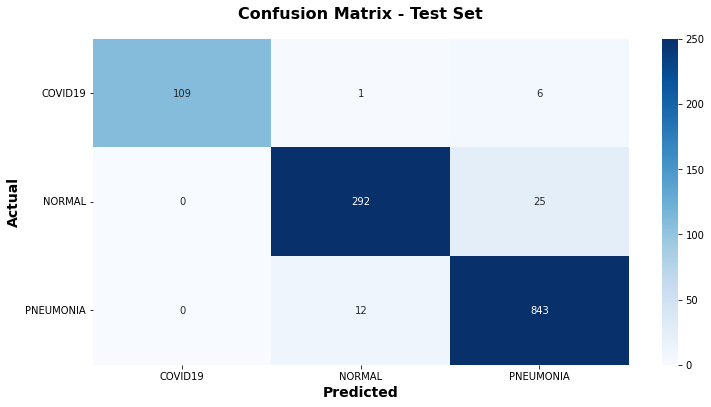

In [ ]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model_3.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## Heat Map

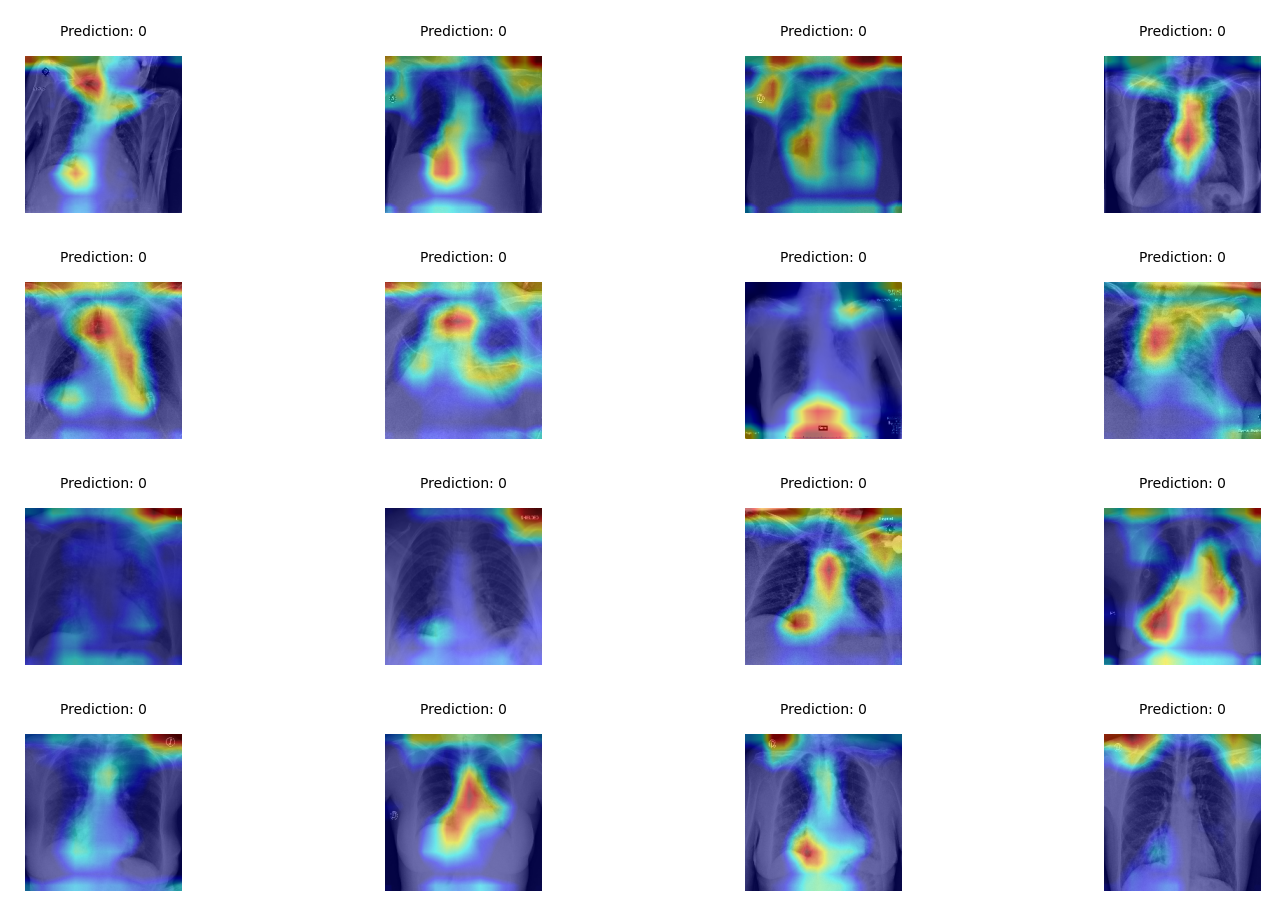

In [ ]:
os.chdir("/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/vizgradcam")


from gradcam import VizGradCAM
for i in range(16):
  # define subplot
  plt.rcParams["figure.dpi"] = 250
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  img = test_generator.__getitem__(i)
  preview_img, preview_labels = img
  pred = model_3.predict(preview_img[0].reshape(1, 224, 224, 3))
  plt.title("Prediction: " + str(pred.argmax()),fontsize = 4)
  plt.axis('off')
  VizGradCAM(model_3, preview_img[0])